In [3]:
import tensorflow as tf
import numpy as np
import os
%matplotlib inline
import matplotlib.pyplot as plt
from Skeleton import Skeleton
from scipy.misc import imsave

In [4]:
def applyMask(img, segmentedUser):
    """
    Applies mask on the given image for visualization.
    """
    if len(img.shape) > 2: # Color image
        mask3 = segmentedUser > 150
        masked_img = img * mask3
    else:
        mask2 = np.mean(segmentedUser, axis=2) > 150
        masked_img = img * mask2
    return masked_img

def read_and_decode_sequence(filename_queue, config):
    # Create a TFRecordReader.
    readerOptions = tf.python_io.TFRecordOptions(compression_type=tf.python_io.TFRecordCompressionType.GZIP)
    reader = tf.TFRecordReader(options=readerOptions)
    _, serialized_example = reader.read(filename_queue)
    
    # Read one sequence sample.
    # The training and validation files contains the following fields:
    # - label: label of the sequence which take values between 1 and 20.
    # - length: length of the sequence, i.e., number of frames.
    # - depth: sequence of depth images. [length x height x width x numChannels]
    # - rgb: sequence of rgb images. [length x height x width x numChannels]
    # - segmentation: sequence of segmentation maskes. [length x height x width x numChannels]
    # - skeleton: sequence of flattened skeleton joint positions. [length x numJoints]
    #
    # The test files doesn't contain "label" field.
    # [height, width, numChannels] = [80, 80, 3]
    with tf.name_scope("TFRecordDecoding"):
        context_encoded, sequence_encoded = tf.parse_single_sequence_example(
                serialized_example,
                # "label" and "lenght" are encoded as context features. 
                context_features={
                    "label": tf.FixedLenFeature([], dtype=tf.int64),
                    "length": tf.FixedLenFeature([], dtype=tf.int64)
                },
                # "depth", "rgb", "segmentation", "skeleton" are encoded as sequence features.
                sequence_features={
                    "depth": tf.FixedLenSequenceFeature([], dtype=tf.string),
                    "rgb": tf.FixedLenSequenceFeature([], dtype=tf.string),
                    "segmentation": tf.FixedLenSequenceFeature([], dtype=tf.string),
                    "skeleton": tf.FixedLenSequenceFeature([], dtype=tf.string),
                })

        # Fetch required data fields. 
        seq_rgb = tf.decode_raw(sequence_encoded['rgb'], tf.uint8)
        seq_depth = tf.decode_raw(sequence_encoded['depth'], tf.uint8)
        seq_segmentation = tf.decode_raw(sequence_encoded['segmentation'], tf.uint8)
        seq_skeleton = tf.decode_raw(sequence_encoded['skeleton'], tf.float32)
        seq_len = tf.to_int32(context_encoded['length'])
        seq_label = context_encoded['label']
        # Tensorflow requires the labels start from 0. Before you create submission csv,
        # increment the predictions by 1.
        seq_label = seq_label - 1
        
        
        #[seq_len, num_skeleton_joints]
        seq_skeleton = tf.reshape(seq_skeleton, (seq_len, 180))
        
        # Reshape images.
        #[seq_len, height, width, num_channels]
        seq_rgb = tf.to_float(tf.reshape(seq_rgb, (-1, config['img_height'], config['img_width'], 3)))
        seq_depth = tf.to_float(tf.reshape(seq_depth, (-1, config['img_height'], config['img_width'], 1)))
        seq_segmentation = tf.to_float(tf.reshape(seq_segmentation, (-1, config['img_height'], config['img_width'], 3)))
    
        sample = {}
        sample['rgb'] = seq_rgb
        sample['depth'] = seq_depth
        sample['segmentation'] = seq_segmentation
        sample['skeleton'] = seq_skeleton
        sample['seq_len'] = seq_len
        sample['labels'] = seq_label
        
        return sample
    

def input_pipeline(filenames, config):
    with tf.name_scope("input_pipeline"):
        # Create a queue of TFRecord input files.
        filename_queue = tf.train.string_input_producer(filenames, num_epochs=config['num_epochs'], shuffle=True)
        # Read the data from TFRecord files, decode and create a list of data samples by using threads.
        sample_list = [read_and_decode_sequence(filename_queue, config) for _ in range(config['ip_num_read_threads'])]
        # print(sample_list)
        # Create batches.
        # Since the data consists of variable-length sequences, allow padding by setting dynamic_pad parameter.
        # "batch_join" creates batches of samples and pads the sequences w.r.t the max-length sequence in the batch.
        # Hence, the padded sequence length can be different for different batches.
        batch_sample = tf.train.batch_join(sample_list,
                                            batch_size=config['batch_size'],
                                            capacity=config['ip_queue_capacity'],
                                            enqueue_many=False,
                                            dynamic_pad=True,
                                            name="batch_join_and_pad")

        return batch_sample

In [5]:
'''
A simple test routine:
'''
config = {}
config['img_height'] = 80
config['img_width'] = 80
config['img_num_channels'] = 3
config['num_epochs'] = 10
config['batch_size'] = 16
# Capacity of the queue which contains the samples read by data readers.
# Make sure that it has enough capacity.
config['ip_queue_capacity'] = config['batch_size']*10  
config['ip_num_read_threads'] = 6
# Directory of the data.
config['data_dir'] = "/Users/zhou/Machine_Perception/mp18-dynamic-gesture-recognition/train"
# File naming
config['file_format'] = "dataTrain_%d.tfrecords"
# File IDs to be used for training.
config['file_ids'] = list(range(1,2))

# Create a list of TFRecord input files.
filenames = [os.path.join(config['data_dir'], config['file_format'] % i) for i in config['file_ids']]

# Create data loading operators. This will be represented as a node in the computational graph.
# Each <key,value> pair in `batch_sample_dict_op` corresponds to Tensorflow placeholder. Alternatively we could 
# load data into memory and feed to the model by using feed_dict approach.
batch_sample_dict_op = input_pipeline(filenames, config)

# Create tensorflow session and initialize the variables (if any).
sess = tf.Session()
init_op = tf.group(tf.global_variables_initializer(),tf.local_variables_initializer())
sess.run(init_op)
# Create threads to prefetch the data.
# https://www.tensorflow.org/programmers_guide/reading_data#creating_threads_to_prefetch_using_queuerunner_objects
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess=sess, coord=coord)

In [6]:
# Fetch a batch of samples.
batch_sample_dict = sess.run(batch_sample_dict_op)

G.X. Edit

In [7]:
for key, value in batch_sample_dict.items() :
    print (key)

depth
labels
rgb
segmentation
seq_len
skeleton


In [8]:
batch_sample_dict['seq_len']

array([60, 60, 60, 60, 60, 60, 71, 71, 71, 71, 71, 71, 59, 59, 59, 59],
      dtype=int32)

In [9]:
batch_sample_dict['skeleton']

(16, 71, 180)

In [10]:
batch_sample_dict['segmentation'].shape

(16, 71, 80, 80, 3)

In [11]:
batch_sample_dict['depth'].shape

(16, 71, 80, 80, 1)

In [12]:
batch_sample_dict['depth'][0][12]

array([[[  0.],
        [  0.],
        [  0.],
        ...,
        [  0.],
        [  0.],
        [  0.]],

       [[  0.],
        [  0.],
        [  0.],
        ...,
        [  0.],
        [  0.],
        [  0.]],

       [[  0.],
        [  0.],
        [  0.],
        ...,
        [  0.],
        [  0.],
        [  0.]],

       ...,

       [[122.],
        [ 97.],
        [124.],
        ...,
        [117.],
        [115.],
        [111.]],

       [[122.],
        [101.],
        [119.],
        ...,
        [117.],
        [115.],
        [111.]],

       [[123.],
        [101.],
        [119.],
        ...,
        [117.],
        [115.],
        [111.]]], dtype=float32)

In [13]:
batch_sample_dict['labels']

array([19, 19, 19, 19, 19, 19,  4,  4,  4,  4,  4,  4, 10, 10, 10, 10])

# Samples: 16
Sequence lengths: [60 60 60 60 60 60 71 71 71 71 71 71 59 59 59 59]
Sequence labels: [19 19 19 19 19 19  4  4  4  4  4  4 10 10 10 10]
Sequence shape: (16, 71, 80, 80, 3)
Image shape: (80, 80, 3)


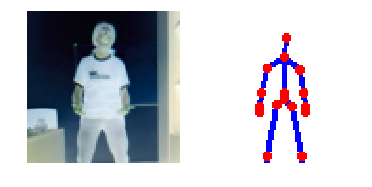

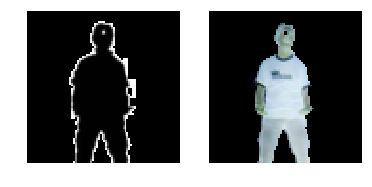

In [18]:
# Print 
print("# Samples: " + str(len(batch_sample_dict['rgb']))) # config['batch_size'] = 16
print("Sequence lengths: " + str(batch_sample_dict['seq_len']))
print("Sequence labels: " + str(batch_sample_dict['labels']))

# Note that the second dimension will give maximum-length in the batch, i.e., the padded sequence length.
print("Sequence shape: " + str(batch_sample_dict['rgb'].shape))

# Fetch first clips 11th frame.
img = batch_sample_dict['rgb'][10][20]
mask = batch_sample_dict['segmentation'][10][20]
print("Image shape: " + str(img.shape))

skeleton = Skeleton(batch_sample_dict['skeleton'][10][20])
skeleton.resizePixelCoordinates()
skeleton_img = skeleton.toImage(img.shape[0], img.shape[1])
masked_img = applyMask(img,mask)

# Show the images. Note that the rgb image looks strange due to the normalization.
plt.figure()
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(skeleton_img)
plt.axis("off")

plt.figure()
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(mask)
plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(masked_img)
plt.axis("off")

imsave('test-img.png', img)
imsave('test-mask.png', mask)
imsave('test-masked.png', masked_img)

In [26]:
batch_sample_dict['skeleton'][10][20].shape

(180,)

In [27]:
skeleton_img.shape

(80, 80, 3)